In [1]:
import pyscf
import matplotlib as plt


/mnt/c/Users/sergio.muniz/Desktop/VQE/.venv/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

#Aqui expresamos la molécula que queremos determinar, en este caso, es un H2, donde cada átomo se encuentra  en la posición de abajo.
molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, -0.37), (0.0, 0.0, 0.37)], charge=0, multiplicity=1)

driver = PySCFDriver.from_molecule(molecule, basis="sto3g")

problem = driver.run()

#En este paso se van a congelar los electrones de las capas del núcleo, esto se debe a que estamos realizando la aproximación de Born-Oppenheimer.
transformer = FreezeCoreTransformer()

# and you also apply transformers explicitly
problem = transformer.transform(problem)

secqop = problem.hamiltonian.second_q_op()
#El resultado de esta medida viene en amstrongs y se trata del hamiltoniano del problema
print("\n".join(str(secqop).splitlines()[:10] + ["..."]))


Fermionic Operator
number spin orbitals=4, number terms=36
  -1.2533097866459775 * ( +_0 -_0 )
+ -0.4750688487721778 * ( +_1 -_1 )
+ -1.2533097866459775 * ( +_2 -_2 )
+ -0.4750688487721778 * ( +_3 -_3 )
+ 0.33737796340722415 * ( +_0 +_0 -_0 -_0 )
+ 0.33185570067540676 * ( +_0 +_1 -_1 -_0 )
+ 0.33737796340722415 * ( +_0 +_2 -_2 -_0 )
+ 0.33185570067540676 * ( +_0 +_3 -_3 -_0 )
...


In [3]:
from qiskit_nature import settings

settings.use_pauli_sum_op = False

Esta forma de expresar el hamiltoniano no está expresada en función de las matrices de Pauli, necesitamos transformarla. Para ello vamos a utilizar el siguiente desarrollo.

In [4]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()
qubit_op = mapper.map(secqop)
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

-0.81217061 * IIII
+0.17141283 * IIIZ
-0.22343154 * IIZI
+0.12062523 * IIZZ
+0.17141283 * IZII
+0.16868898 * IZIZ
+0.16592785 * IZZI
+0.04530262 * XXXX
+0.04530262 * XXYY
+0.04530262 * YYXX
+0.04530262 * YYYY
-0.22343154 * ZIII
+0.16592785 * ZIIZ
+0.17441288 * ZIZI
+0.12062523 * ZZII


Como vemos hemos conseguido expresar el hamiltoniano en términos de los operadores de Pauli, de esta forma podremos utilizar el método del VQE. A continuación veremos como determinar el 'ground-state' <br>
Para poder ejecutar el algoritmo necesitamos un estado inicial o ansatz, para poder generar uno vamos a utilizar el módulo EfficientSU2

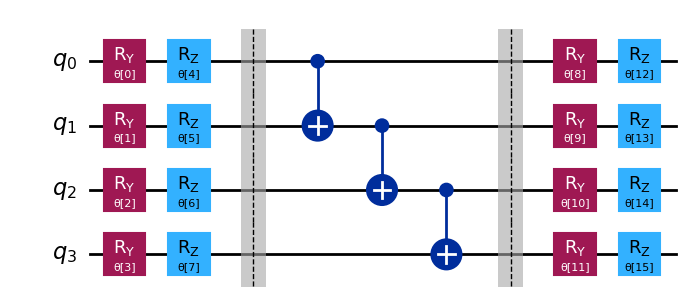

In [5]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear",
insert_barriers = True)
ansatz.decompose().draw("mpl")

El hecho de que el entrelazamiento sea linear quiere decir que cada qubit esta entrelazado utilizando una CNOT solamente con el qubit siguiente, en total hay 16 parámetros que podemos editar, las cuales vienen dadas en las puertas de rotación, ahora necesitamos introducir una VQE instance para resolver el problema.

In [10]:
import numpy as np
from qiskit_algorithms import VQE
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler
#from qiskit.utils import algorithm_globals
import numpy as np
from qiskit_algorithms.optimizers import COBYLA

# define Aer Estimator for noiseless statevector simulation
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 1235
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

optimizer = COBYLA()

initial_point = np.random.random(ansatz.num_parameters)


vqe = VQE(noiseless_estimator,ansatz=ansatz, optimizer=optimizer ,
initial_point=initial_point)

In [11]:

result = vqe.compute_minimum_eigenvalue(qubit_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 194,
    'eigenvalue': -1.8347106653000738,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7ff2f7248ca0>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -0.2007628205579669,
                              ParameterVectorElement(θ[1]): -0.02831816746117746,
                              ParameterVectorElement(θ[2]): 0.35291471813779945,
                              ParameterVectorElement(θ[3]): 0.8898297722144153,
                              ParameterVectorElement(θ[4]): -0.2933419507442,
                              ParameterVectorElement(θ[5]): 3.161238028075619,
                              ParameterVectorElement(θ[6]): -0.2677839966571221,
                              ParameterVectorElement(θ[7]): -0.006109897408882194,
                              ParameterVectorElement(θ[8]): 3.210505975950131,
                              ParameterVectorElement(θ[9]):

Como este problema tiene una dimensión pequeña se puede resolver clásicamente de forma exacta, la forma de hacerlo es la siguiente

In [13]:
from qiskit_algorithms import NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(qubit_op)
print(result)

{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([ 1.28613849e-16+8.15760303e-17j,
             -9.54974868e-17-2.38172604e-17j,
             -4.05013474e-17+7.40040363e-18j,
              1.22025241e-16-3.88047089e-17j,
             -1.68103211e-16-6.54827875e-17j,
             -9.76629899e-01-1.83106292e-01j,
              2.18536388e-16-3.16668350e-16j,
             -2.19541358e-17-8.04707587e-17j,
             -2.05565945e-17-6.23545471e-18j,
              2.68022674e-16-3.60183335e-16j,
              1.10616499e-01+2.07392554e-02j,
              4.29485480e-17-8.36616949e-17j,
              2.07512419e-16+1.58888994e-16j,
              4.92434717e-17-1.47892886e-18j,
              7.94118583e-17+1.78773721e-16j,
              9.87925522e-18-9.16860650e-17j],
            dims=(2, 2, 2, 2)),
    'eigenvalue': -1.852388173569584}


In [9]:
from qiskit.quantum_info import Statevector
statevector =result._eigenstate


for i in range(0,16):
    if abs(statevector[i]) < 0.000000001:
        statevector[i] = 0
    print(f'{i}',statevector[i])

TypeError: 'Statevector' object does not support item assignment

In [ ]:

from qiskit_nature.second_q.drivers import PySCFDriver
#Introducimos el problema físico, en este caso se trara de una molécula de hidrógeno
driver = PySCFDriver(atom="H 0 0 -0.37; H 0 0 0.37", basis="sto-3g")
problem = driver.run()

from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()

#Determinar el ansatz
ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear",
insert_barriers = True)


import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

# Se puede también introducir un estado_inicial aleaotorio, pero no entiendo muy bien para que sirve
vqe = VQE(Estimator(), ansatz, COBYLA())



result = vqe.compute_minimum_eigenvalue(qubit_op)
print(result)


{   'aux_operators_evaluated': None,
    'cost_function_evals': 320,
    'eigenvalue': -1.852388172259822,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x7f308ffd8ee0>,
    'optimal_parameters': {   ParameterVectorElement(θ[2]): 3.141602702018184,
                              ParameterVectorElement(θ[4]): 0.3116368134771757,
                              ParameterVectorElement(θ[1]): 3.141610521073244,
                              ParameterVectorElement(θ[5]): 1.8933779029362787,
                              ParameterVectorElement(θ[7]): 1.783433346781338,
                              ParameterVectorElement(θ[6]): -3.0603029484085944,
                              ParameterVectorElement(θ[3]): -7.268077658557997e-06,
                              ParameterVectorElement(θ[15]): 2.344792473561983,
                              ParameterVectorElement(θ[9]): 3.25498385634213e-05,
                              ParameterVectorElement(θ[12]):

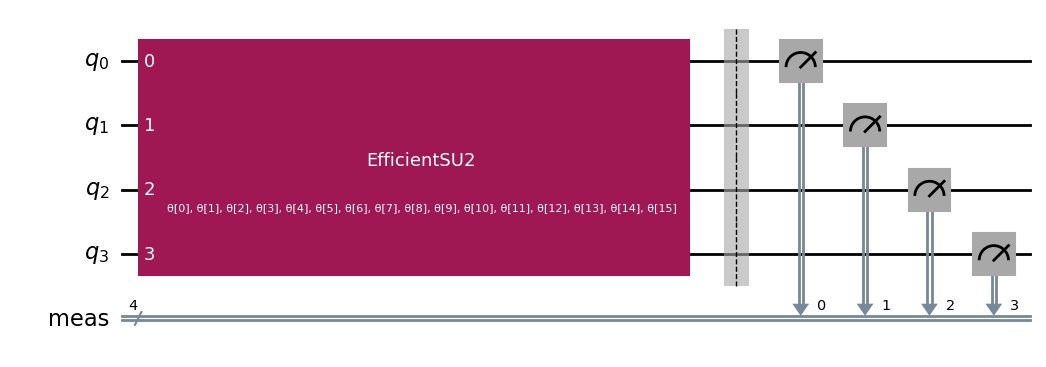

In [ ]:
from qiskit import QuantumCircuit,transpile

from qiskit_aer import AerSimulator
sim = AerSimulator()

qc=QuantumCircuit(4,4)
qc=result.optimal_circuit


qc.measure_all()
qc.draw('mpl')

In [ ]:
optimal_points=result.optimal_parameters
param_values = [value for value in optimal_points.values()]

print("Array de valores de los parámetros:")
print(param_values)

Array de valores de los parámetros:
[2.9159899126979134, 3.141610521073244, 3.141602702018184, -7.268077658557997e-06, 0.3116368134771757, 1.8933779029362787, -3.0603029484085944, 1.783433346781338, 2.832703008995049e-05, 3.25498385634213e-05, 1.621767356223769e-05, -3.1415569589539176, 2.6655854357549167, 0.246352329765348, -0.38602172601593854, 2.344792473561983]


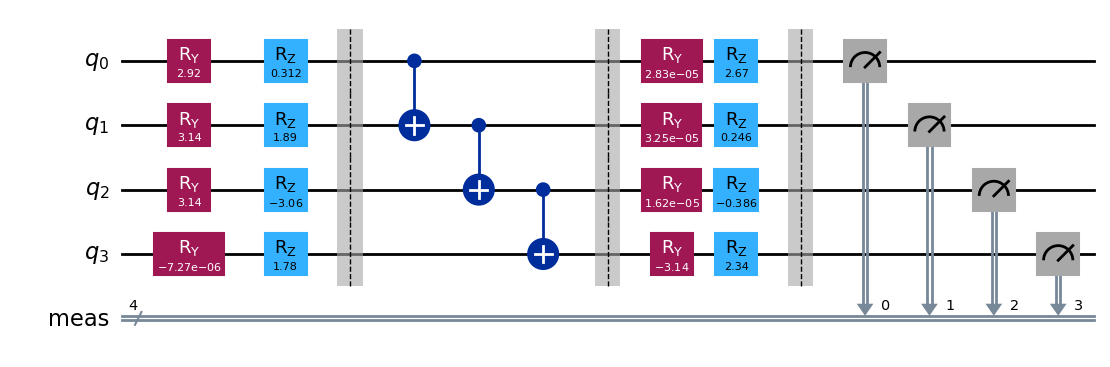

In [ ]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import Statevector

# Crea una instancia del ansatz EfficientSU2
ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear", insert_barriers=True)

# Define los valores de los parámetros
parameters = param_values # Por ejemplo, una lista de valores para los parámetros

# Asigna los valores de los parámetros al ansatz
bound_ansatz = ansatz.assign_parameters(parameters)

# Puedes obtener el circuito resultante con los valores asignados
bound_circuit = bound_ansatz

# Dibujar el circuito resultante
qc2=QuantumCircuit(4,4)
qc2=bound_circuit.decompose()

qc2.measure_all()
qc2.draw('mpl')

In [ ]:
from qiskit.providers.basic_provider import BasicSimulator
backend = BasicSimulator()
tqc2 = transpile(qc2, backend)
counts = backend.run(tqc2).result().get_counts()
 
print(counts)

{'0101': 1013, '1010': 11}


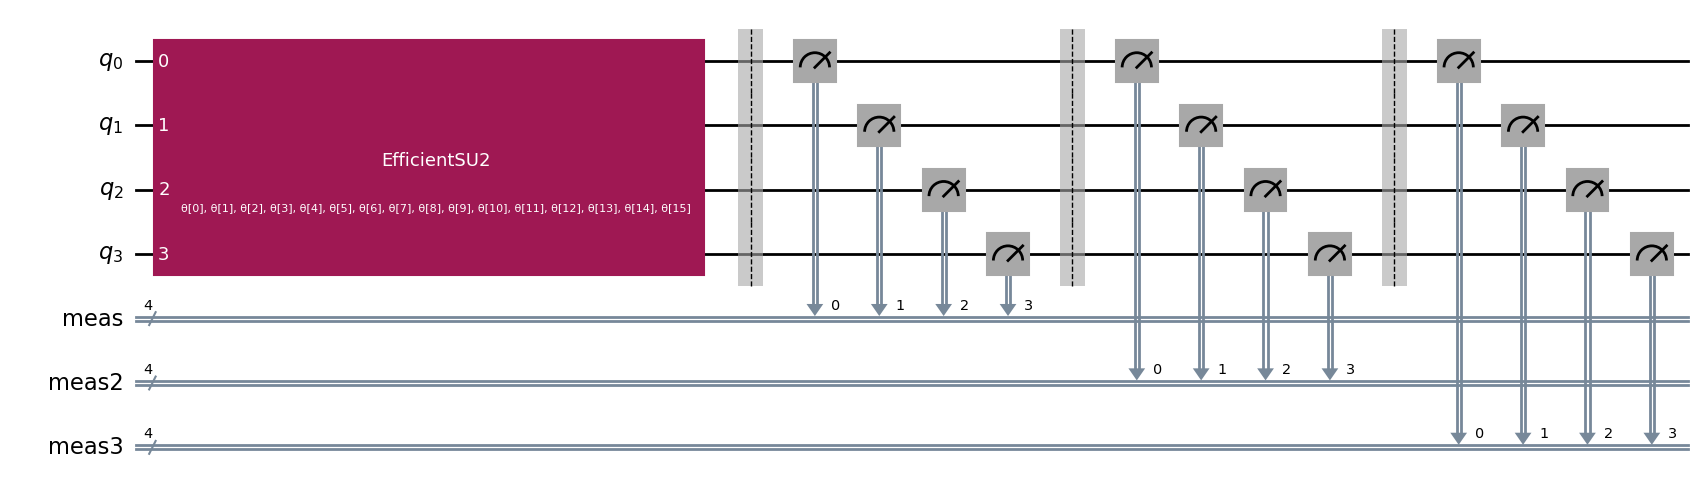

In [ ]:
from qiskit import QuantumCircuit,transpile

from qiskit_aer import AerSimulator
sim = AerSimulator()

qc=QuantumCircuit(4,4)
qc=result.optimal_circuit
qc.measure_all()
qc.draw('mpl')

In [ ]:
from qiskit.providers.basic_provider import BasicSimulator
backend = BasicSimulator()
tqc = transpile(qc, backend)
counts = backend.run(tqc).result().get_counts()
 
print(counts)

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([ParameterVectorElement(t[0]), ParameterVectorElement(t[1]), ParameterVectorElement(t[2])])]'

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper

driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735")
problem = driver.run()

hamiltonian = problem.hamiltonian.second_q_op()

mapper = ParityMapper(num_particles=problem.num_particles)

qubit_op = mapper.map(hamiltonian)
aux_ops = {}
aux_ops.update(mapper.map(problem.properties.particle_number.second_q_ops()))
aux_ops.update(mapper.map(problem.properties.angular_momentum.second_q_ops()))

In [ ]:
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

initial_point = HFInitialPoint()
initial_point.ansatz = ansatz
initial_point.problem = problem

solver = VQE(Estimator(), ansatz, SLSQP())
solver.initial_point = initial_point.to_numpy_array()

result = solver.compute_minimum_eigenvalue(qubit_op, aux_ops)
print(f"Eigenvalue = {result.eigenvalue: .10f}")

Eigenvalue = -1.8572750301
